# COGS 108 - Final Project 

# Overview

Our project is focused on providing predictions on prices for new AirBnB future rental listings based on information on previous listings. We have a user interface able to collect information on a listing we are trying to predict and use that to compare listings with the similar criteria. For the prediction, we are using two types of models, ARIMA and Prophet, to forecast future listing prices and compare the results to gain a better understanding on how the AirBnB market in San Diego will change in the future. Check out the demo of our [our interface here](https://drive.google.com/file/d/1oOl0JxchD3CKjYQ00o6BKH_UuiJpyWzy/view?usp=sharing).

# Names

- Anish Donepudi
- Andrew Shen
- Ayush More
- Ryan Kane
- Tanveer Mittal

# Research Question

        How well can we model the pricing strategies of airbnb rental listings in San Diego? How accurately can we predict prices for new listings?

## Background and Prior Work

        We, as non-local San Diego residents, have noticed the housing situation and gentrification that exists within the area, contrasting neighborhoods and perspectives from the extravagant mansions Del Mar to compacted housing units of Chula Vista. From personally seeing the strong divide of socio-economic lifestyles, we drew conclusions about the AirBnB price listing, specifically on how the different variables such as the area and types of reviews affect these prices. 
        Airbnb pricing was a question of interest for our group because many of us are renting or looking to rent places in the San Diego area and Airbnb has been a large source of controversy regarding rental property over the past few years, citing, “Short-term rental hosts have long argued they should have the right to use their properties as a way of supplementing their income while residents have complained about the emergence of “mini hotels” disrupting their once quiet neighborhoods.” (3) Airbnb or short term rentals have a large impact on both renters and hosts as they are a shift from the standard long term contracts that many have to sign and often cheaper than hotels. Looking from the perspective of the host, we want to look at how they determine their prices and what factors affect how they charge their rent. By determining a process to generate the most efficient price it makes it easy for hosts to competitively price their rooms while also lowers prices for renters.
        There have been algorithms and programs designed to model and predict the most optimal pricing structures to use however they have a few problems. One such tool created by Dan Hill stated “… the tool still had two weaknesses. The tips it gave were static…” (2) Other models such as BeyondPricing offer professional services such as, “Your listing will be updated daily based on changes in supply and demand in the market, day of week, seasonality, and local events.”(4) but come at a large expense for small term tenants. There are more advanced programs such as an updated tool by Dan Hill which used “... a machine-learning model called a classifier. It uses all of the attributes of a listing and prevailing market demand and then attempts to classify whether it will get booked or not. Our system calculates price tips based on hundreds of attributes… ”(2) The problem with this program is that it used data only accessible by Airbnb themselves and would not be as applicable to rental property outside of Airbnb.


References (include links):
- 1) https://spectrum.ieee.org/computing/software/the-secret-of-airbnbs-pricing-algorithm
- 2) https://www.sandiegouniontribune.com/business/tourism/sd-fi-airbnb-regulations-council-20181022-story.html
- 3) https://beyondpricing.com/

# Hypothesis


       Given the information of an AirBnb listing (i.e location, reviews), the model created will be able to accurately predict the price of these listings as well as future prices within those areas. 
        We believe pricings will be heavily influenced by the area surrounding them, with more expensive listings located near the oceanfront and less expensive listings more inland. The neighborhoods that are closer to the oceanfront like Del Mar are more luxurious and thus expensive compared to areas like Chula Vista.
        Also, we predict that AirBnB listings will be more popular during vacation seasons given the San Diego reputation compared to other seasons such as Winter. As a result, we should expect the prices of the listings to fluctuate in accordance with the influx of tourists.


# Dataset(s)

Inside AirBnb Dataset
- http://insideairbnb.com/index.html
- 13574 listings

The dataset from Airbnb contains two csv files that we will be using for our analysis; listings.csv and calendar.csv.

Listings contains information about each listing posted onto Airbnb. This is information that the owner of the room has provided about the room that they are trying to rent out. This file contains many different variables however we will primarity be focusing on the number of guests that can fit in the room, the number of bedrooms and beds, the zipcode the room is located in, and lastly, the average review of the listing.

Calendar contains information about each listing on a specific date. We will be using this dataset to find the price of each listing over the course of multiple nights. For this dataset, we will be focusing on the listing id, the date, and the price of the listing on that date. 

We will be building our timeseries off of a combination of these two datasets. Lisings contains the information on the room listed on Airbnb and Calendar will contain the price information on the listed room.



# Setup

In [3]:
%matplotlib inline
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, datetime, timedelta
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings('ignore')
plt.style.use("fivethirtyeight")

In [7]:
listings = pd.read_csv(os.path.join("data", "listings.csv"))
calendar = pd.read_csv(os.path.join("data", "calendar.csv"))

# Data Cleaning

### Listings

Listings is going to have all of our data about each AirBnb room

In [8]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5570,https://www.airbnb.com/rooms/5570,20191121092222,2019-11-21,Ocean front condo on the sand,Missionbeachretreat. Great Ocean Front Condo...,This charming two bedroom beachfront condomini...,Missionbeachretreat. Great Ocean Front Condo...,none,While some may compare San Diego’s Mission Bea...,...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,NaN
1,8488,https://www.airbnb.com/rooms/8488,20191121092222,2019-11-21,Juniper Zen Palace- SD's Best Hood!,Walk every where in San Diegos most charming a...,Private craftsman home in the heart of Histori...,Walk every where in San Diegos most charming a...,none,South Park is a charming community and our nei...,...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.36
2,29967,https://www.airbnb.com/rooms/29967,20191121092222,2019-11-21,"Great home, 10 min walk to Beach","This 2 bedroom, 2 full bathroom home offers al...","This two bedroom (1 CA king bed, 1 queen bed),...","This 2 bedroom, 2 full bathroom home offers al...",none,NaN,...,f,f,moderate,f,f,5,5,0,0,0.53
3,38245,https://www.airbnb.com/rooms/38245,20191121092222,2019-11-21,Point Loma/Liberty Station-NTC,Stay in a 1928 Spanish Style home. Den is dow...,Please note: 1928 home; remodeled in 2015. Co...,Stay in a 1928 Spanish Style home. Den is dow...,none,"This neighborhood is an expensive, high-end Po...",...,f,f,moderate,t,t,3,0,3,0,1.28
4,39516,https://www.airbnb.com/rooms/39516,20191121092222,2019-11-21,Art Studio Retreat/Rustic Cabin,We love having explorers from all over the wor...,"Nestled in South/North Park, a gentrified neig...",We love having explorers from all over the wor...,none,"We love our eclectic neighborhood, with a smal...",...,f,f,strict_14_with_grace_period,t,f,1,1,0,0,3.38


As seen there are over 100 columns. We'll clean Listings to only get the columns informaiton valueable to us.

In [9]:
listings = listings[['id','accommodates','bedrooms','beds', 'zipcode', 'review_scores_rating']]
listings.head()

,id,accommodates,bedrooms,beds,zipcode,review_scores_rating
0,5570,6,2.0,4.0,92109,NaN
1,8488,5,3.0,3.0,92104,97.0
2,29967,8,2.0,3.0,92109,98.0
3,38245,1,1.0,1.0,92106,86.0
4,39516,2,1.0,1.0,92104,98.0


Here is our final dataframe. These columns in listings are already fairly clean. The missings values in review_scores_rating are just taken to mean a room with a review rating of 0.

### Calendar

Calendar is going to contain the price of each listing on each day

In [10]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,5570,2019-11-21,f,"$2,050.00","$2,050.00",3,365
1,5570,2019-11-22,f,"$2,050.00","$2,050.00",3,365
2,5570,2019-11-23,f,"$2,050.00","$2,050.00",3,365
3,5570,2019-11-24,f,"$2,050.00","$2,050.00",3,365
4,5570,2019-11-25,f,"$2,050.00","$2,050.00",3,365


Just like listings we will remove all the columns with unnecessary information.

In [11]:
calendar = calendar[['listing_id','date','price']]

This time we'll also drop any rows with missing values.

In [41]:
calendar.dropna().head()

,listing_id,date,price
0,5570,2019-11-21,2050.0
1,5570,2019-11-22,2050.0
2,5570,2019-11-23,2050.0
3,5570,2019-11-24,2050.0
4,5570,2019-11-25,2050.0


The next step is to clean the date and price columns in calendar. To clean data, we will need to convert all objects in data to datatime objects.

In [13]:
calendar['date'] = pd.to_datetime(calendar['date'])

To clean price, we will first create a fuction dollar_to_number. This will convert a string into an number value. Then we will apply it to the price column.

In [14]:
def dollar_to_number(string):
    string = string.replace('$', '')
    string = string.replace(',', '')
    string = string.replace('.', '')
    number = int(string)/100
    return number

In [15]:
calendar['price'] = calendar['price'].apply(dollar_to_number)
calendar.head()

### Interface functions

For our interface, we will be predicting our prices off various criteria. We are collecting:
- \# of guests
- \# of bedrooms (optional)
- Area (optional)
- \# of beds (optional)
- Reviews (optional)

Number of guests will be the only required criteria with all other details being optional to provide.

In order to create time series that our interface can use in forecasting, we need to be able to seperate out different types of Airbnb's from each other. To do that we define the function, filter_room_details, that will take in specific parameters about each room and only return listings that meet those parameters.

In [17]:
# returns a df with rooms that meet room critera
def filter_room_details(df, num_guests, num_bedrooms, num_beds, area, review):
    
    # get rooms greater than max_num_guests
    df_filtered_room = df[(df['accommodates'] ==  num_guests) 
                        & (df['bedrooms']  >=  num_bedrooms)
                        & (df['beds']  >=  num_beds)
                        & (df['review_scores_rating']  >=  review)]
    
    # if area is given get rooms in area
    if area != 0:
        df_filtered_room = df_filtered_room.loc[df_filtered_room['zipcode']  ==  area]

    
    return df_filtered_room

Here we can test this function by finding all rooms with: 
- capacity for 6 guests
- located in 92109
- a review score greater than 80

In [18]:
num_guests = 6
zipcode = 92109
minimum_review = 80

df_filter_room_details_test = filter_room_details(listings, num_guests, 0, 0, zipcode, minimum_review)
df_filter_room_details_test.head()

,id,accommodates,bedrooms,beds,zipcode,review_scores_rating
10,69385,6,3.0,4.0,92109,97.0
94,395071,6,2.0,5.0,92109,95.0
187,766826,6,3.0,0.0,92109,99.0
194,797668,6,2.0,4.0,92109,96.0
203,821576,6,2.0,2.0,92109,94.0
...,...,...,...,...,...,...
7987,26258281,6,2.0,3.0,92109,95.0
8009,26331580,6,2.0,2.0,92109,87.0
8058,26452943,6,3.0,3.0,92109,100.0
8126,26602212,6,2.0,4.0,92109,92.0


As you can see there are 321 listings on AirBnb that meet those 3 criteria. Because we did not specify the number of bedrooms or beds, you can see some variance in those between each listing.

Now we will take the dataframe created from filter_room_details and the calendar dataframe inorder to create a timeseries. create_time_series will take in a filtered dataset of listings, match the listing with the listing in calendar, and group all the prices by date to calculate the average price on a set date.

In [23]:
# returns a df with rooms that meet time critera
def create_time_series(df_listings, df_calendar):
    # get listing ids from df_listings
    id_list = df_listings['id'].to_list()
    
    #remove ids from df_calendar that are not in id_list
    df_calendar_filtered = df_calendar[df_calendar['listing_id'].isin(id_list)]
        
    # group items by date and find the average price on that day
    df_calendar_filtered = df_calendar_filtered.groupby(['date']).mean()
    
    #convert and return as series
    series = pd.Series(df_calendar_filtered['price'])
    return series

This will return the average prices on each day for all the listings that met our intital criteria.

To test this function we'll use the filtered data frame from before and calendar to create the timeseries for our criteria. Its important to note however that our dataset only covers listings and prices between 2019-11-21 and 2020-11-19.

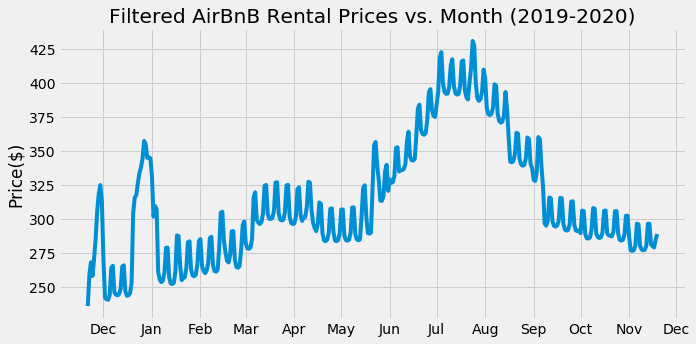

In [27]:
df_timeseries_test = create_time_series(df_filter_room_details_test, calendar)
# Plot timeseries
fig = plt.figure(figsize=(10, 5))
months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(months_fmt)
plt.ylabel("Price($)")
plt.title("Filtered AirBnB Rental Prices vs. Month (2019-2020)")
plt.plot(df_timeseries_test);

# Data Analysis & Results

In order to forecast future prices of Airbnb's we need to perform some exploratory data analysis to understand the behavior of prices throughout the year.

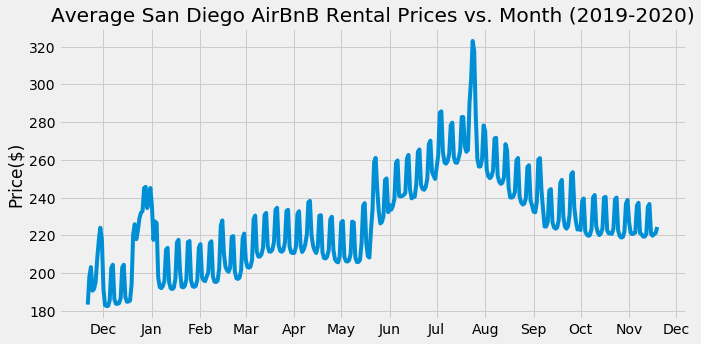

In [28]:
# Create and plot time series
avg_prices = create_time_series(listings, calendar)
fig = plt.figure(figsize=(10, 5))
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(months_fmt)
plt.ylabel("Price($)")
plt.title("Average San Diego AirBnB Rental Prices vs. Month (2019-2020)")

plt.plot(avg_prices.index, avg_prices)
plt.savefig("plots/averagePrice.png")

From the plot above we can clearly see that the average price fluctuates through the year with a general upward trend through the spring and spikes in January/July. Interestingly, Comic Con in San Diego happens around the time of the spike in July which brings a lot of traveleres to San Diego and could explain this pheonomon. The graph also has constant movement daily. To explore this we will visualize the prices of a single month in detail.

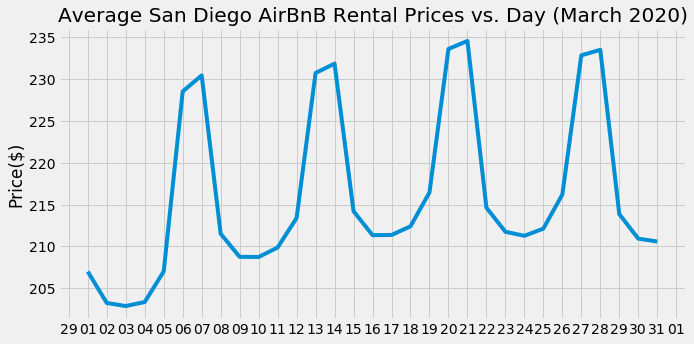

In [34]:
# Create and plot time series of prices in march
march_prices = avg_prices[avg_prices.index.month == 3]
fig = plt.figure(figsize=(10, 5))
days = mdates.DayLocator()
days_fmt = mdates.DateFormatter('%d')
plt.gca().xaxis.set_major_locator(days)
plt.gca().xaxis.set_major_formatter(days_fmt)
avg_prices = calendar.groupby("date").mean()["price"]
plt.ylabel("Price($)")
plt.title("Average San Diego AirBnB Rental Prices vs. Day (March 2020)")
plt.plot(march_prices.index, march_prices);
plt.savefig("plots/averagePrice.png")

Throughout each week, the average price of an Airbnb changes. From this graph, we can see that the prices peak each weekend and this movement is constantly happening. In order to properly forecast the price of an Airbnb, our model will need to at least use the last week of prices to create an informed prediction. To start building our model we need to look at the autocorrelations of the time series.

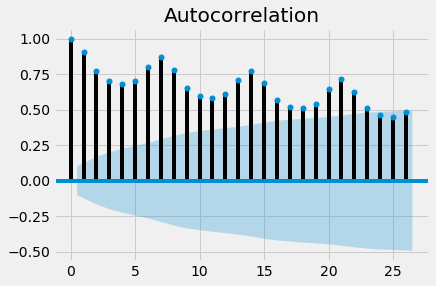

In [5]:
plot_acf(avg_prices);

From this plot we cannot clearly estimate the order of lag our data is correlated with. This plot suggests that the time series we are dealing with is non-stationary. To figure this out, we use the Augmented Dickey Fuller test with a significance level of 5%. Our Null Hypothesis for this test is that our time series is stationary.

In [31]:
adf_test = adfuller(avg_prices) 
adf = adf_test[0]
cv_5 = adf_test[4]["5%"]
adf < cv_5 

False

Because our observed p-value is less than 0.05, we must reject the null hypothesis, and work the assumption that Airbnb prices are not stationary. To deal with this we will most likely have difference our time series for forecasting. To get an idea of the order of lag our data is correlated with, we must look at the plot of partial autocorrelations.

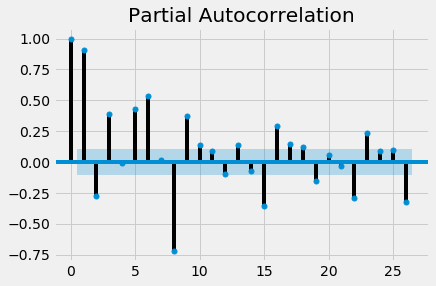

In [8]:
plot_pacf(avg_prices);

From this plot, we can see that most lags past 9 have insignificant partial autocorrelations, meaning that our autoregressive forecasting model should likely use the 9 previous values to to forecast the next value. In order for us to evaluate our model we need to split our data into training and testing partitions.

The following function is to help us get the latest data from the AirBnb data website. We are directly going to scrape the calendar.csv file from the San Diego table. Then based on the listing.csv that we already have, we are then only getting the data of the listings from listings.csv. There is a parameter of date which is default to 2020-11-20 because we have data till that day but it can be set to anything past that and the function will return the dataframe that can be used to help forecasting the price.

In [1]:
def get_latest_calendar(date = '2020-11-20'):
    # the website we need to access to get the data
    bnbdata = "http://insideairbnb.com/get-the-data.html"
    # requesting to access the website
    page = requests.get(bnbdata)
    # using BeautifulSoup package as an HTML  parser
    soup = BeautifulSoup(page.content, 'html.parser')

    # finding the San Diego data table on the website and creating a list of csv file links
    table = soup.find("table", class_="table table-hover table-striped san-diego").find_all('a')

    # need to convert the HTML language into just plain links which is stored in results
    result = []
    for i in table:
        result.append(i.get("href"))

    # we need to be able to access the calendar.csv file from the page which will always be in the first index of the list because it would be the most up to date data
    latest_calendar_df = pd.read_csv(result[1])
    # accessing all the listings that we want to find the data for in calendar.csv
    listing_df = pd.read_csv(r'data/listings.csv')
    # creating a hash set of all the unique ids within the listings.csv
    idset = set(listing_df.id.unique())
    # deleting all the rows that do not have the listing ids listed in idset
    latest_calendar_df = latest_calendar_df[latest_calendar_df.listing_id.isin(idset)]

    # finding all the unique dates that exist in the calendar dataframe
    arr2 = latest_calendar_df.date.unique()
    # only need data that is past the date of 2020-11-19 so needed to find the index of the '2020-11-20'
    index = np.where(arr2 == date)
    # making a set with the dates that we will be able to use because it is all the new data we dont have
    arr2 = set(arr2[index[0][0]:])
    # delete all the rows that do not have the need data
    latest_calendar_df = latest_calendar_df[latest_calendar_df.date.isin(arr2)]
    # reindex the new dataframe which has all the new data within it
    latest_calendar_df = latest_calendar_df.reset_index(drop=True)
    return latest_calendar_df



In [36]:
split_date = date(2020, 10, 1)
train_part = avg_prices[avg_prices.index.date < split_date]
test_part = avg_prices[avg_prices.index.date >= split_date]

In [37]:
# Function to calculate rmse using residual values
calculate_rmse = lambda res: np.sqrt((res ** 2).sum()/(len(res)))

We decided to pursue a Auto Regressive Integrated Moving Average(ARIMA) model to forecast future prices. The model has 3 significant hyperparameters that we need to adjust accordingly to our data:
- The autoregression order(p): The number of previous prices used to estimate current prices. This was estimated to be 9 using the partial autocorrelation plot above
- The differencing order(d): The order of differencing that needs to be done on our data. Using the augmented dickey fuller test, we found that the prices were not stationary, therefore we believe that this parameter will need to be greater than 0 to account for the time series being non-stationary.
- The moving average size(q): The number values used in calculating a moving average.

To properly find these values we will use appropriate grid searches to find the parameters that minimize Akaike Information Criteria(AIC) and the Bayesian Information Criteria(BIC), which measure how well the model is fitting our data, and also minimize our root mean squared error on both the training and testing paritions.

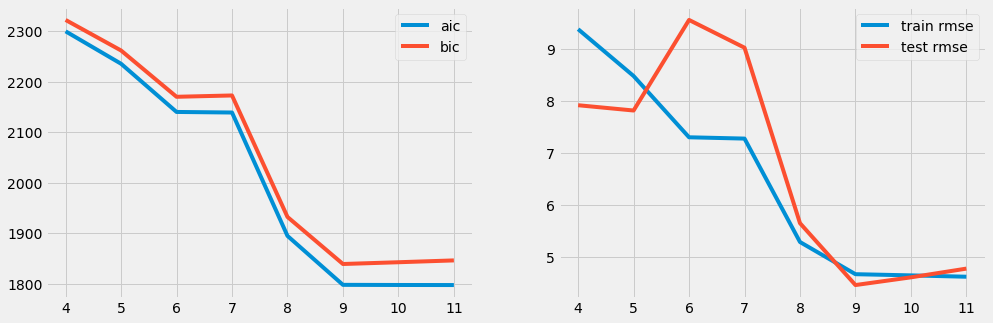

In [13]:
# Search to find optimal Autoregression order
ar_search = pd.DataFrame(columns=["aic", "bic", "train rmse", "test rmse"])
for i in range(4, 12):
    # Fit AR model
    ar_model = ARIMA(train_part, order=(i, 0, 0))
    ar_res = ar_model.fit()
    
    # Calculate metrics
    train_rmse = calculate_rmse(ar_res.resid)
    test_preds = ar_res.forecast(len(test_part))[0]
    test_rmse =  calculate_rmse(test_preds - test_part)
    
    # Add metrics to dataframe
    ar_search.loc[i] = (ar_res.aic, ar_res.bic, train_rmse, test_rmse)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ar_search.plot(y=["aic", "bic"], ax=ax1)
ar_search.plot(y=["training rmse", "test rmse"], ax=ax2);

In [55]:
# AR model with optimal order from search
ar_model = ARIMA(train_part, order=(9, 0, 0))
ar_res = ar_model.fit()

From the plots generated above we can see that past an autoregressive order of 9, there is minimal benefit in our model's performance which supports the observation from our partial autocorrelation plot above. To find the rest of our parameters we will fix our model's autoregressive order at 9 and search for the optimal differencing and moving average values for our model.

In [15]:
# Define parameter search space and dataframe to store metrics
grid_search = pd.DataFrame(columns=["d", "q", "aic", "bic", "train rmse", "test rmse"])
diff_search_space = [0, 2]
ma_search_space = list(range(7))
search_space = [(9, d, q) for d in diff_search_space for q in ma_search_space]
for i, params in enumerate(search_space):
    # Fit ARIMA model
    arima_model = ARIMA(train_part, order=params)
    arima_res = arima_model.fit()
    
    # Calculate metrics
    train_rmse = calculate_rmse(arima_res.resid)
    test_preds = arima_res.forecast(len(test_part))[0]
    test_rmse =  calculate_rmse(test_preds - test_part)
    
    # Add metrics to dataframe
    grid_search.loc[i] = (params[1], params[2], arima_res.aic, arima_res.bic, train_rmse, test_rmse)

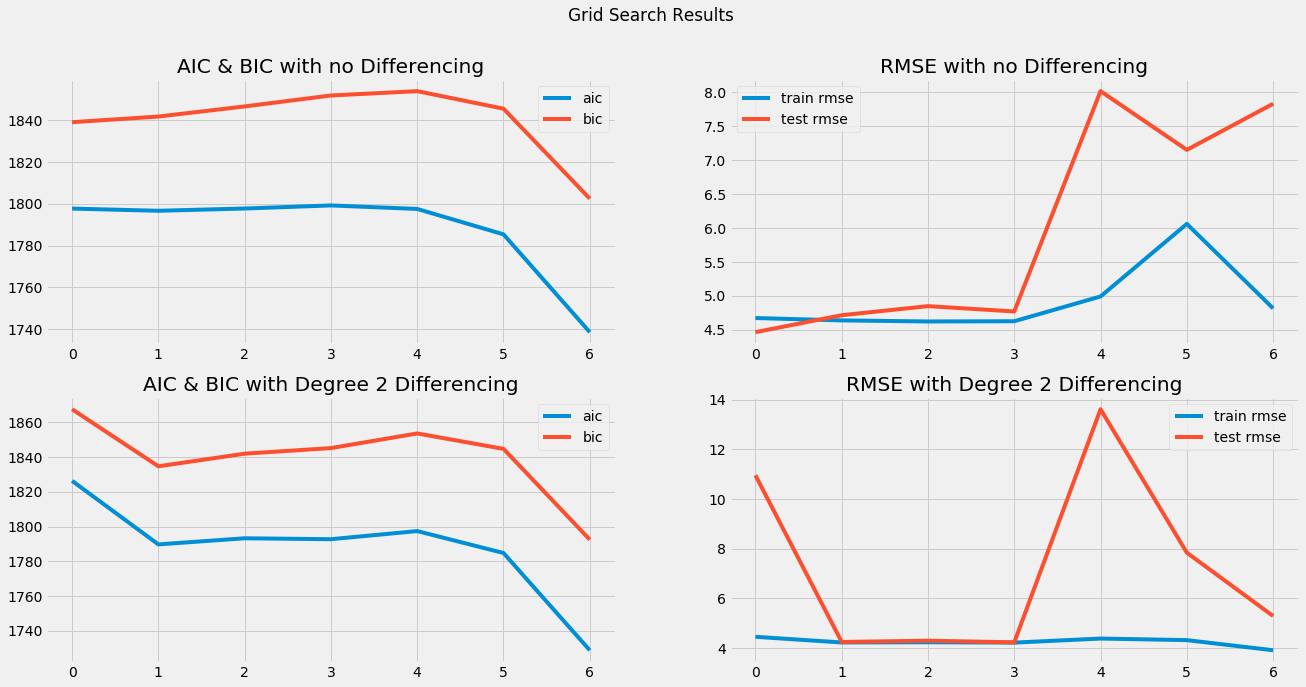

In [16]:
# Visualizing the results of the grid search
diff0 = grid_search.groupby("d").get_group(0).reset_index(drop=True)
diff2 = grid_search.groupby("d").get_group(2).reset_index(drop=True)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Grid Search Results")
axes[0, 0].title.set_text("AIC & BIC with no Differencing")
axes[0, 1].title.set_text("RMSE with no Differencing")
axes[1, 0].title.set_text("AIC & BIC with Degree 2 Differencing")
axes[1, 1].title.set_text("RMSE with Degree 2 Differencing")
diff0.plot(y=["aic", "bic"], ax=axes[0, 0])
diff0.plot(y=["train rmse", "test rmse"], ax=axes[0, 1])
diff2.plot(y=["aic", "bic"], ax=axes[1, 0])
diff2.plot(y=["training rmse", "test rmse"], ax=axes[1, 1]);

In [17]:
# View params that minimize aic, bic, and rmse
indices = grid_search.drop(["d", "q"], axis=1).idxmin()
grid_search[["d", "q"]].iloc[indices].set_index(indices.index)

,d,q
aic,2.0,6.0
bic,2.0,6.0
train rmse,2.0,6.0
test rmse,2.0,3.0


In [45]:
# Best hyperparameters from grid search
arima_model = ARIMA(train_part, order=(9, 2, 6))
arima_res = arima_model.fit()

In [19]:
# Save model parameters to disk
pickle.dump(ar_res.params, open(os.path.join("models", "AR_params.pkl"), "wb+"))
pickle.dump(arima_res.params, open(os.path.join("models", "ARIMA_params.pkl"), "wb+"))

From the plots and dataframe above, we can see that a differencing order of 2 and a moving average size of 6 is optimal for our model's performance. This makes sense as our model would want to use a large portion of the last week of prices to forecast and 2nd order differencing would induce stationarity on this time series. Below we will continue to evaluate model performance.

In [20]:
# Modeling evaluation
print("AR Training RMSE:", calculate_rmse(ar_res.resid))
print("AR Out of Sample Testing RMSE:", calculate_rmse(ar_res.forecast(len(test_part))[0] - test_part))
print("ARIMA Training RMSE:", calculate_rmse(arima_res.resid))
print("ARIMA Out of Sample Testing RMSE:", calculate_rmse(arima_res.forecast(len(test_part))[0] - test_part))

AR Training RMSE: 4.673898710485799
AR Out of Sample Testing RMSE: 4.465872868722263
ARIMA Training RMSE: 3.9141778317839093
ARIMA Out of Sample Testing RMSE: 5.291150234840783


From the values above we can see that the ARIMA model is fitting the data better than the autoregressive model, however it is not performing better on the testing partition. One important thing to note is that the predictions that are used to compute RMSE on the testing partition are naive. Any prediction that is not within our training data starts to use previously forecasted values towards the next predictions rather than real world prices. To validate performance on the testing partition using step by step forecasting we have written the experiment below.

In [40]:
# Load previous parameters
ar_params = pickle.load(open(os.path.join("models", "AR_params.pkl"), "rb+"))
arima_params = pickle.load(open(os.path.join("models", "ARIMA_params.pkl"), "rb+"))
# Series to store model predictions
ar_predictions = test_part.copy() * 0
arima_predictions = test_part.copy() * 0
# Series with last 60 days of prices
history = train_part.copy().iloc[-60:]
for date in test_part.index:
    # Fit models on updated data
    model1 = ARIMA(history, order=(9, 0, 0))
    model_res1 = model1.fit(ar_params)
    model2 = ARIMA(history, order=(9, 2, 6))
    model_res2 = model2.fit(arima_params)
    # Make new forecasts and update price history
    ar_predictions.loc[date] = model_res1.forecast()[0]
    arima_predictions.loc[date] = model_res2.forecast()[0]
    history.loc[date] = test_part[date]
    history = history.iloc[1:]

# Calculate RMSE
ar_error = mean_squared_error(test_part, ar_predictions)
arima_error = mean_squared_error(test_part, arima_predictions)
print("AR Testing RMSE:", ar_error)
print("ARIMA Testing RMSE:", arima_error)

AR Testing RMSE: 5.047564333614198
ARIMA Testing RMSE: 4.294007300900177


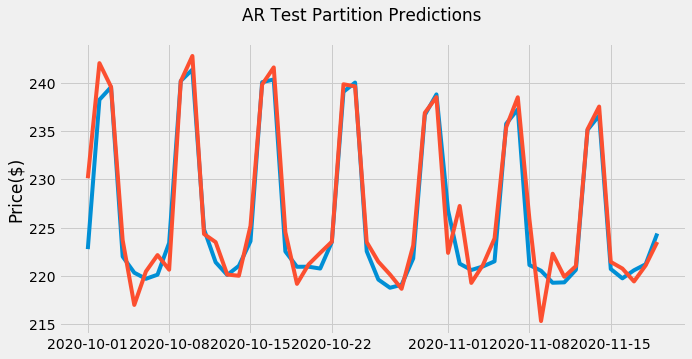

In [42]:
# Plot AR model's predicted
fig = plt.figure(figsize=(10, 5))
fig.suptitle("AR Test Partition Predictions")
plt.ylabel("Price($)")
plt.plot(test_part)
plt.plot(ar_predictions);

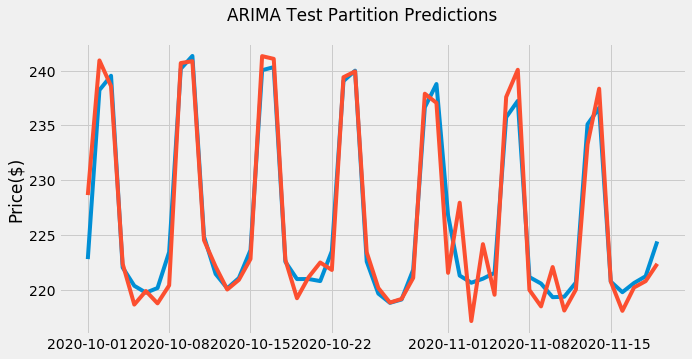

In [43]:
# Plot predicted vs. actual price
fig = plt.figure(figsize=(10, 5))
fig.suptitle("ARIMA Test Partition Predictions")
plt.ylabel("Price($)")
plt.plot(test_part)
plt.plot(arima_predictions);

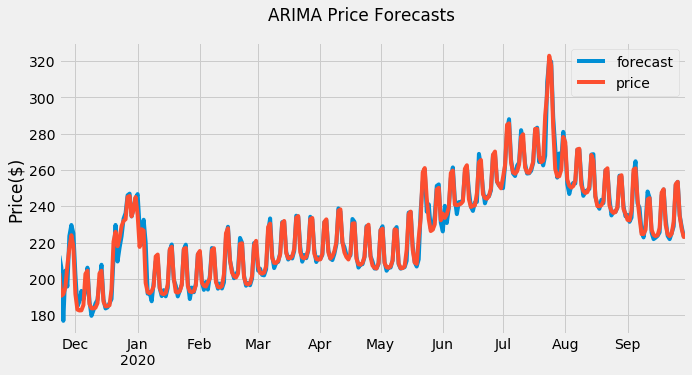

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("ARIMA Price Forecasts")
plt.ylabel("Price($)")
arima_res.plot_predict(ax=ax);

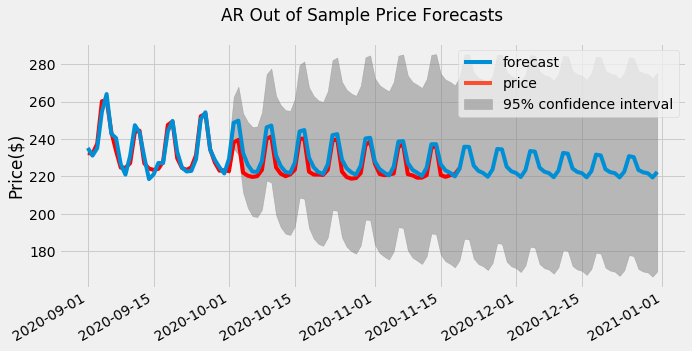

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))
subset = avg_prices[avg_prices.index.date >= date(2020, 9, 1)]
fig.suptitle("AR Out of Sample Price Forecasts")
plt.ylabel("Price($)")
ax.plot(subset, c='r');
ar_res.plot_predict(date(2020, 9, 1), date(2020, 12, 31), ax=ax);
ax.lines.pop(2);

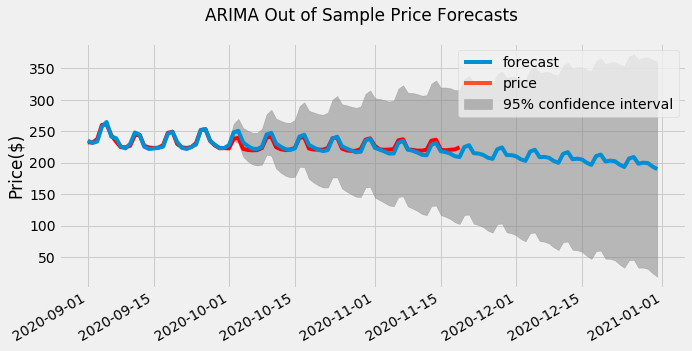

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
subset = avg_prices[avg_prices.index.date >= date(2020, 9, 1)]
fig.suptitle("ARIMA Out of Sample Price Forecasts")
plt.ylabel("Price($)")
ax.plot(subset, c='r');
arima_res.plot_predict(date(2020, 9, 1), date(2020, 12, 31), ax=ax)
ax.lines.pop(2);

From the plots above we can see that our models perform well on this data. We can also note 2 distinct differences between the autoregressive and ARIMA models. The autoregressive model doesn't model the general trend of the time series as well as ARIMA. The ARIMA model's forecasts past the last training point trend downwards while the Autoregressive forecasts simply decay in amplitude. This was due to the fact that the ARIMA model applies differencing to account for the non-stationary behavior of the data which the autoregressive model did not account for.

To try out different models with the data, we decided to create a Facebook Prophet forecasting model. The process is similar to the ARIMA modeling in that we used the same train and test data and predicts future prices for AirBnB listings.

In [22]:
dfPro = pd.DataFrame()
dfPro['y'] = train_part
dfPro = dfPro.reset_index().rename(columns = {'date': 'ds'})
dfPro

,ds,y
0,2019-11-21,183.263518
1,2019-11-22,197.970900
2,2019-11-23,203.130838
3,2019-11-24,190.625313
4,2019-11-25,191.547959
...,...,...
310,2020-09-26,253.467217
311,2020-09-27,234.605127
312,2020-09-28,227.417047
313,2020-09-29,223.048475


In [40]:
prophet = Prophet(weekly_seasonality = True)
prophet.fit(dfPro)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


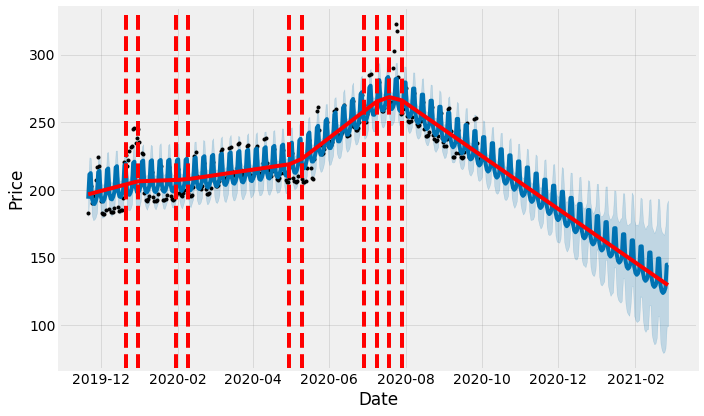

In [46]:
future = prophet.make_future_dataframe(periods= 150, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast, xlabel = 'Date', ylabel = "Price")

a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

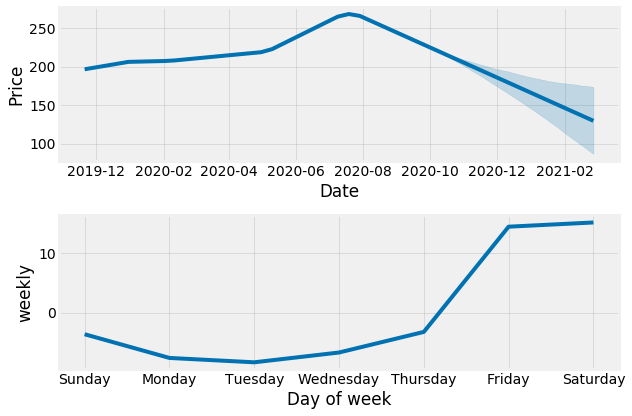

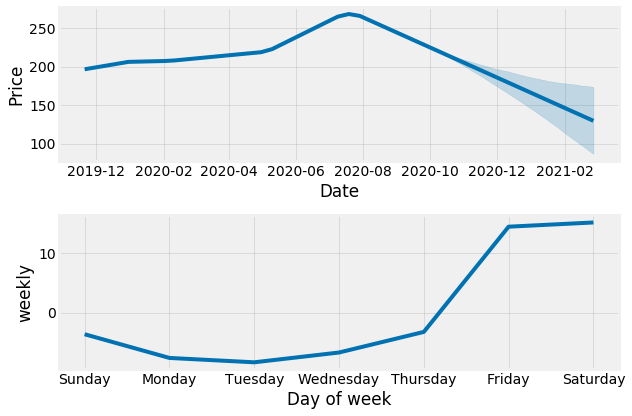

In [47]:
fig2 = prophet.plot_components(forecast)
axes = fig2.get_axes()
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
fig2

In [48]:
df_cv = cross_validation(prophet, initial = '10 days' , horizon = '30 days')
df_cv.head()

INFO:fbprophet:Making 19 forecasts with cutoffs between 2019-12-05 00:00:00 and 2020-08-31 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-06,188.233363,187.056400,189.305583,202.664800,2019-12-05
1,2019-12-07,181.670379,179.092459,183.696507,204.421320,2019-12-05
2,2019-12-08,156.318423,151.222581,160.965513,186.066893,2019-12-05
3,2019-12-09,147.908004,139.717311,154.949577,183.698320,2019-12-05
4,2019-12-10,145.453927,134.398367,155.424535,183.674156,2019-12-05


In [57]:
train_error = np.sqrt(mean_squared_error(train_part, df_cv['yhat'].iloc[:len(train_part)]))
test_error = np.sqrt(mean_squared_error(test_part, df_cv['yhat'].iloc[len(train_part):len(train_part)+len(test_part)]))

In [68]:
print("Prophet Training MSE:", train_error)
print("Prophet Test MSE:", test_error)

Prophet Training MSE: 48.605139884455525
Prophet Test MSE: 16.64261359166329


In [49]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,300.403756,17.332160,12.733442,0.057893,0.037606,0.701754
1,4 days,382.126632,19.548060,14.104541,0.064376,0.038867,0.666667
2,5 days,446.588424,21.132639,15.149863,0.068475,0.039487,0.631579
3,6 days,486.835721,22.064354,15.923623,0.070559,0.040392,0.614035
4,7 days,497.177216,22.297471,16.494808,0.071889,0.045918,0.596491
5,8 days,529.721598,23.015682,17.004675,0.074286,0.047127,0.561404
6,9 days,582.466565,24.134344,17.457135,0.077698,0.047127,0.561404
7,10 days,688.407091,26.237513,18.469693,0.084124,0.058647,0.561404
8,11 days,803.117397,28.339326,19.739528,0.090619,0.060705,0.526316
9,12 days,872.966870,29.546013,20.924793,0.096010,0.063080,0.491228


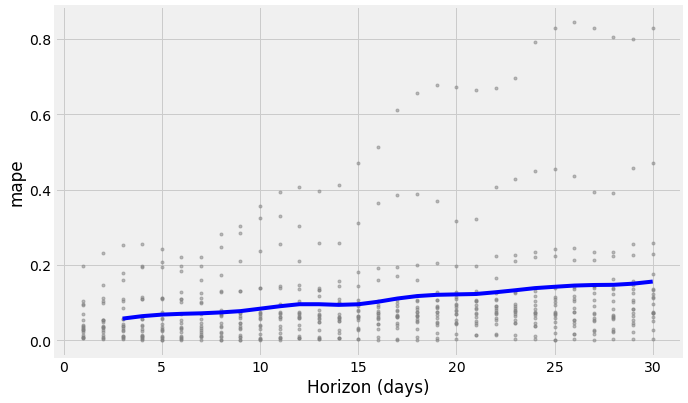

In [50]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [68]:
print("Prophet Training MSE:", train_error)
print("Prophet Test MSE:", test_error)

Prophet Training MSE: 48.605139884455525
Prophet Test MSE: 16.64261359166329


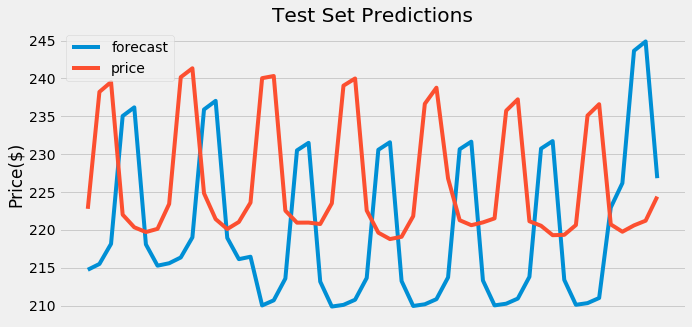

In [64]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.ylabel("Price($)")
plt.title("Test Set Predictions")
plt.plot(df_cv['yhat'].iloc[len(train_part):len(train_part)+len(test_part)].reset_index(drop=True))
plt.plot(test_part.values)
plt.legend(["forecast", "price"]);

# Ethics & Privacy

        In order to protect participants’ data, by only using the listing id number, number of people the Airbnb can hold, number of bedrooms, number of beds, zip code, and the rating of the place on Airbnb. The calendar data frame that we used contained listing id, date, and the price.  All of the data that we have within our data frames after cleaning would be the general data that could be used for analysis without putting the property owner’s privacy at risk. We were able to get all the data from insideairbnb.com/get-the-data.html, and it seems like there are no issues against using any of this data. It is for the public to use and nowhere in the terms and conditions did it say that we could not scrape data from the website. So, we made it possible for us to scrape from the website whenever we needed data from any specific date onwards. Ethically, we have made sure to explain all of the analysis in an honest and accurate way. Our data seem to show no potential biases. We have done our best to take care of most of the ethical and privacy issues that tend to come up when dealing with dataset analysis.

# Conclusion & Discussion

We were able to accomplish the goals of our project, outlined earlier in the quarter. Our interface allows for users to easily select criteria and then view forecasts for the specified listings. To see it in action please check out the [our demo here](https://drive.google.com/file/d/1oOl0JxchD3CKjYQ00o6BKH_UuiJpyWzy/view?usp=sharing).

Overall the autoregressive and ARIMA models perform very well on the training and test sets. The models struggle, however, when we cut off the last actual value used in forecasting around points of change. For example if our model only saw the data before a significant peak, its predictions would have large errors as the forecasts would continue to trend upwards while the actual values undergo a mean reversion. The model does not have this problem if it is used in a case where the forecasting is done step by step to forecast only the next day’s price.

Compared to the ARIMA model, the Facebook Prophet model did not do as well as we expected on the training and testing sets. One interesting characteristic we noticed with the forecast predictions compared to the prices was that it seemed to be misclassified when the peaks of the prices are throughout the time period. As seen with the “Test Set Predictions” graph, both follow a similar trend, but fail to match the times when it peaks. As a result, the model did not fare well against the ARIMA model when comparing both the graphs as well as the root mean squared error.

The impact of this work on society is that individuals will be able to get an approximate price of an Airbnb to their interest. Right now, this is limited to just the data of San Diego but it can be implemented in a way to find any dataset from any city and get a forecasted price of the Airbnb. This will allow Airbnb users to see the trends of the pricing and know what to expect. A very useful tool that can be an aid when planning trips.


# Team Contributions

    Ryan – Creating the interface for users to enter their criteria                                                      
    Anish – Constructed a function that scrapes from Airbnb for latest data
    Andrew – Constructed univariate time series function & accessing specific listings by id function
    Ayush – Constructing a function that fits prophet model to data
    Tanveer – Constructs a function that forecasts prices & constructs function that fits the ARIMA model to data
